<a href="https://colab.research.google.com/github/s-stockton/past_work/blob/master/Stockton_Blinds_Company_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Blinds Company Neural Network Analysis

This notebook contains 14 neural networks that attempt to predict repairs, customer ordered repairs, and remakes. The same machine learning parameters are used for all 14 neural networks. Each neural network has one input layer, three hidden layers, and an output layer. Each neural network is trained on 75% of the data and tests on 25% of the data, using 10 epochs during the training cycle.

Please note that since it is essentially the same process for each neural network, the only annotated cellblock is the first complete neural network, "Silhouette/Nantucket Repair."


# Loading/installing packages

In [ ]:
"""
@author: s-stockton
"""
!pip install sklearn
!pip install neupy

import pickle
import json
import numpy as np
import sklearn
from numpy import genfromtxt
from sklearn.model_selection import cross_validate
import io
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
initial_df = pd.read_csv(io.BytesIO(uploaded['Xxxxx Xxxxxxx Quality Data 50K.csv']))

# Cleaning dataset

This portion is only for the 50K data loaded above. The main data cleaning was performed in R.

---



In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_df.REASON_CODE.isna()

0        True
1        True
2        True
3        True
4        True
         ... 
49995    True
49996    True
49997    True
49998    True
49999    True
Name: REASON_CODE, Length: 50000, dtype: bool

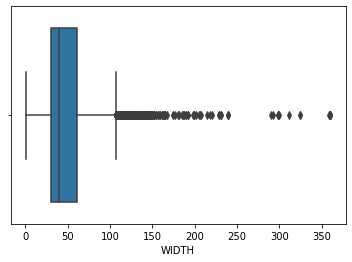

In [ ]:
import seaborn as sns
sns.boxplot(x=initial_df['WIDTH'])

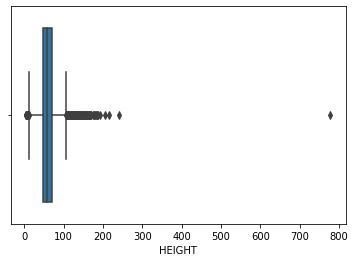

In [ ]:
sns.boxplot(x=initial_df['HEIGHT'])

In [ ]:
print((initial_df.HEIGHT==0).unique())
print((initial_df.WIDTH==0).unique())

[False]
[False]


Keeping HEIGHT and WIDTH between 1 and 400 (384 is max width I could find online), and using the same metric to remove the HEIGHT outlier seen above.

In [ ]:
df = initial_df.drop(initial_df[(initial_df['HEIGHT'] >= 400.0) | (initial_df['HEIGHT'] > 1.0) | (initial_df['WIDTH'] >= 400.0) | (initial_df['WIDTH'] > 1.0)].index)

df = df.reset_index(drop=True)

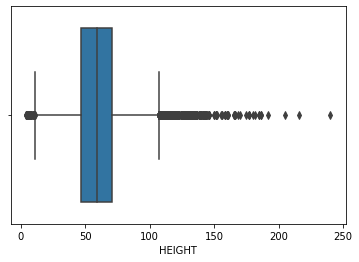

In [ ]:
sns.boxplot(x=df['HEIGHT'])


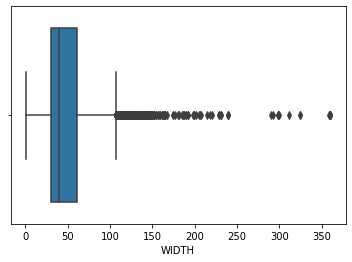

In [ ]:
sns.boxplot(x=df['WIDTH'])

# Silhouette/Nantucket Repair

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SILNAN.csv to SILNAN (1).csv


In [ ]:
initial_silnan = pd.read_csv(io.BytesIO(uploaded['SILNAN.csv'])) # reading the data into a pandas dataframe

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x) # display numbers properly

In [ ]:
# filtering dataset to the variables used in neural network
initial_silnan = initial_silnan[['ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
# creating new binary variable for REPAIR == 1 if if ORDER_REASON_ID == "REP", otherwise REP == 0. 
initial_silnan['REPAIR']=initial_silnan['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REP' else 0)

In [ ]:
# removing ORDER_REASON_ID from dataframe
initial_silnan = initial_silnan.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
# drop na, they cannot run in the neural network arrays
initial_silnan = initial_silnan.dropna()

In [ ]:
# creating a dataframe that will contain all transformed binary variables. it was a precautionary step,
# as the mapping transformations above can cause errors to be thrown. this just makes
# a cleaner copy to use in the following binary transformation
silnan_df = initial_silnan.copy()

Below is the creation of all binary columns that will be transformed into an array to be passed through the neural network. "res" is a dataframe that is overwritten throughout the notebook in each neural network. This was to save disk space.

In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_PLANT']])
res = pd.concat([silnan_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res #looking at the dataframe

,REPAIR,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_G,ORIGINAL_PLANT_P,ORIGINAL_PLANT_T,ORIGINAL_PLANT_V,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,REGION_STATE_ID_BC,REGION_STATE_ID_BS,REGION_STATE_ID_BWI,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_CT,REGION_STATE_ID_DC,...,ORIGINAL_MATERIAL_ID_SILTDBU,ORIGINAL_MATERIAL_ID_SILTDBUDIS,ORIGINAL_MATERIAL_ID_SILTOLP,ORIGINAL_MATERIAL_ID_SILUG,ORIGINAL_MATERIAL_ID_SILUG2,ORIGINAL_MATERIAL_ID_SILUG2DIS,ORIGINAL_MATERIAL_ID_SILUG2DUO,ORIGINAL_MATERIAL_ID_SILUG2DUODIS,ORIGINAL_MATERIAL_ID_SILUG2XL,ORIGINAL_MATERIAL_ID_SILUG2XLDIS,ORIGINAL_MATERIAL_ID_SILUGDIS,ORIGINAL_MATERIAL_ID_SILUGXL,ORIGINAL_MATERIAL_ID_SILUGXLDI,ORIGINAL_MATERIAL_ID_SILXLHW,ORIGINAL_MATERIAL_ID_SOMN,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_HW,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOV,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283494,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
283495,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
283496,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
283497,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = res.iloc[:, 1:].values #create matrix of feature variables. this is everything except REPAIR column (indexing starts at 0)
y = res.iloc[:, 0].values # setting y to be the independent variable, which is the column REPAIR (index 0)

In [ ]:
y = y.reshape(-1,1) # scaling y, mean 0

In [ ]:
# scaling X similar to y above. machine learning performs better with normalized data, mean of 0
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
# transforming y into an array
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
# splitting up data to be 75% train, 25% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

The following code is the structure of the neural network which wil be repeated throughout the notebook. input_dim is the number of expected features to be passed into the network. The first hidden layer contains 40 nodes and uses the relu activation. The second and third hidden layers have 30 and 15 nodes. The ouput layer has 2 nodes and uses the softmax activation to assign predictions

In [ ]:
# importing needed packages
import keras
from keras.models import Sequential
from keras.layers import Dense
# neural network structure
model = Sequential()
model.add(Dense(40, input_dim=1339, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # setting loss function and optimization, using accuracy as a metric

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64) # running the neural network on 10 epochs, assigning weights every 64 rows

Epoch 1/10
206266/206266 [==============================] - 11s 53us/step - loss: 0.0953 - acc: 0.9762
Epoch 2/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0823 - acc: 0.9794
Epoch 3/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0788 - acc: 0.9802
Epoch 4/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0760 - acc: 0.9807
Epoch 5/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0732 - acc: 0.9811
Epoch 6/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0708 - acc: 0.9816
Epoch 7/10
206266/206266 [==============================] - 10s 51us/step - loss: 0.0687 - acc: 0.9818
Epoch 8/10
206266/206266 [==============================] - 11s 52us/step - loss: 0.0670 - acc: 0.9822
Epoch 9/10
206266/206266 [==============================] - 10s 49us/step - loss: 0.0654 - acc: 0.9823
Epoch 10/10
206266/206266 [==============================] - 10s 49us/ste

In [ ]:
# creating labels for neural network output
y_pred = model.predict(X_test)
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 98.0176275525045


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

68756/68756 [==============================] - 3s 37us/step


In [ ]:
print(score)

[0.0869036875061608, 0.980176275525045]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
# transforming y_test, y_pred so they can display on a confusion matrix
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[66834,   143],
       [ 1220,   559]])

# Silhouette Nantucket Remake

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SILNAN.csv to SILNAN.csv


In [ ]:
initial_silnan = pd.read_csv(io.BytesIO(uploaded['SILNAN.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_silnan = initial_silnan[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_silnan['REMAKE']=initial_silnan['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REM' else 0)

In [ ]:
initial_silnan = initial_silnan.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_silnan = initial_silnan.dropna()

In [ ]:
silnan_df = initial_silnan.copy()

In [ ]:
silnan_df.groupby('REMAKE').count()

,ORIGINAL_PLANT,ALLIANCE_LEVEL_ID,REGION_STATE_ID,WIDTH,HEIGHT,FABRIC_ID,COLOR_ID,ORIGINAL_MATERIAL_ID,OPERATING_SYSTEM_ID
REMAKE,,,,,,,,,
0,262531,262531,262531,262531,262531,262531,262531,262531,262531
1,12491,12491,12491,12491,12491,12491,12491,12491,12491


In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_PLANT']])
res = pd.concat([silnan_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_G,ORIGINAL_PLANT_P,ORIGINAL_PLANT_T,ORIGINAL_PLANT_V,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,REGION_STATE_ID_BC,REGION_STATE_ID_BS,REGION_STATE_ID_BWI,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_CT,REGION_STATE_ID_DC,...,ORIGINAL_MATERIAL_ID_SILTDBU,ORIGINAL_MATERIAL_ID_SILTDBUDIS,ORIGINAL_MATERIAL_ID_SILTOLP,ORIGINAL_MATERIAL_ID_SILUG,ORIGINAL_MATERIAL_ID_SILUG2,ORIGINAL_MATERIAL_ID_SILUG2DIS,ORIGINAL_MATERIAL_ID_SILUG2DUO,ORIGINAL_MATERIAL_ID_SILUG2DUODIS,ORIGINAL_MATERIAL_ID_SILUG2XL,ORIGINAL_MATERIAL_ID_SILUG2XLDIS,ORIGINAL_MATERIAL_ID_SILUGDIS,ORIGINAL_MATERIAL_ID_SILUGXL,ORIGINAL_MATERIAL_ID_SILUGXLDI,ORIGINAL_MATERIAL_ID_SILXLHW,ORIGINAL_MATERIAL_ID_SOMN,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_HW,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOV,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283494,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
283495,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
283496,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
283497,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=1339, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
206266/206266 [==============================] - 9s 41us/step - loss: 0.1724 - acc: 0.9539
Epoch 2/10
206266/206266 [==============================] - 8s 41us/step - loss: 0.1573 - acc: 0.9566
Epoch 3/10
206266/206266 [==============================] - 9s 41us/step - loss: 0.1505 - acc: 0.9580
Epoch 4/10
206266/206266 [==============================] - 9s 43us/step - loss: 0.1452 - acc: 0.9591
Epoch 5/10
206266/206266 [==============================] - 9s 42us/step - loss: 0.1408 - acc: 0.9598
Epoch 6/10
206266/206266 [==============================] - 9s 42us/step - loss: 0.1368 - acc: 0.9605
Epoch 7/10
206266/206266 [==============================] - 9s 41us/step - loss: 0.1337 - acc: 0.9608
Epoch 8/10
206266/206266 [==============================] - 8s 41us/step - loss: 0.1311 - acc: 0.9612
Epoch 9/10
206266/206266 [==============================] - 8s 41us/step - loss: 0.1286 - acc: 0.9619
Epoch 10/10
206266/206266 [=======

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 95.79382163011229


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

68756/68756 [==============================] - 2s 28us/step


In [ ]:
print(score)

[0.15579922418297812, 0.9579382163011229]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[65360,   228],
       [ 2664,   504]])

# Silhouette Nantucket CRR

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
initial_silnan = pd.read_csv(io.BytesIO(uploaded['SILNAN.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_silnan = initial_silnan[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_silnan['CREMAKE']=initial_silnan['ORDER_REASON_ID'].apply(lambda x: 1 if x =='CRR' else 0)

In [ ]:
initial_silnan = initial_silnan.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_silnan = initial_silnan.dropna()

In [ ]:
silnan_df = initial_silnan.copy()

In [ ]:
silnan_df.groupby('CREMAKE').count()

,ORIGINAL_PLANT,ALLIANCE_LEVEL_ID,REGION_STATE_ID,WIDTH,HEIGHT,FABRIC_ID,COLOR_ID,ORIGINAL_MATERIAL_ID,OPERATING_SYSTEM_ID
CREMAKE,,,,,,,,,
0,271143,271143,271143,271143,271143,271143,271143,271143,271143
1,3879,3879,3879,3879,3879,3879,3879,3879,3879


In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_PLANT']])
res = pd.concat([silnan_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(silnan_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_G,ORIGINAL_PLANT_P,ORIGINAL_PLANT_T,ORIGINAL_PLANT_V,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,REGION_STATE_ID_BC,REGION_STATE_ID_BS,REGION_STATE_ID_BWI,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_CT,REGION_STATE_ID_DC,...,ORIGINAL_MATERIAL_ID_SILTDBU,ORIGINAL_MATERIAL_ID_SILTDBUDIS,ORIGINAL_MATERIAL_ID_SILTOLP,ORIGINAL_MATERIAL_ID_SILUG,ORIGINAL_MATERIAL_ID_SILUG2,ORIGINAL_MATERIAL_ID_SILUG2DIS,ORIGINAL_MATERIAL_ID_SILUG2DUO,ORIGINAL_MATERIAL_ID_SILUG2DUODIS,ORIGINAL_MATERIAL_ID_SILUG2XL,ORIGINAL_MATERIAL_ID_SILUG2XLDIS,ORIGINAL_MATERIAL_ID_SILUGDIS,ORIGINAL_MATERIAL_ID_SILUGXL,ORIGINAL_MATERIAL_ID_SILUGXLDI,ORIGINAL_MATERIAL_ID_SILXLHW,ORIGINAL_MATERIAL_ID_SOMN,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_HW,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOV,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283494,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
283495,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
283496,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
283497,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=1339, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
206266/206266 [==============================] - 11s 56us/step - loss: 0.0778 - acc: 0.9837
Epoch 2/10
206266/206266 [==============================] - 11s 52us/step - loss: 0.0656 - acc: 0.9863
Epoch 3/10
206266/206266 [==============================] - 11s 53us/step - loss: 0.0620 - acc: 0.9864
Epoch 4/10
206266/206266 [==============================] - 11s 52us/step - loss: 0.0586 - acc: 0.9866
Epoch 5/10
206266/206266 [==============================] - 11s 53us/step - loss: 0.0556 - acc: 0.9868
Epoch 6/10
206266/206266 [==============================] - 12s 58us/step - loss: 0.0534 - acc: 0.9871
Epoch 7/10
206266/206266 [==============================] - 11s 52us/step - loss: 0.0514 - acc: 0.9873
Epoch 8/10
206266/206266 [==============================] - 11s 51us/step - loss: 0.0501 - acc: 0.9874
Epoch 9/10
206266/206266 [==============================] - 10s 50us/step - loss: 0.0483 - acc: 0.9875
Epoch 10/10
206266/206266 [==============================] - 10s 50us/ste

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 98.53685496538483


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

68756/68756 [==============================] - 3s 39us/step


In [ ]:
print(score)

[0.06893583465623508, 0.9853685496503808]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[67663,    72],
       [  934,    87]])

# Honeycomb Repairs

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
initial_honeycomb = pd.read_csv(io.BytesIO(uploaded['HONEYCOMB.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
# color id omitted, original_material_id omitted

In [ ]:
initial_honeycomb = initial_honeycomb[['ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_honeycomb['REPAIR']=initial_honeycomb['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REP' else 0)

In [ ]:
initial_honeycomb = initial_honeycomb.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_honeycomb = initial_honeycomb.dropna()

In [ ]:
honeycomb_df = initial_honeycomb.copy()

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ORIGINAL_PLANT']])
res = pd.concat([honeycomb_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
#dummies = pd.get_dummies(honeycomb_df[['ORIGINAL_MATERIAL_ID']])
#res = pd.concat([res,dummies], axis = 1)
#res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=777, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

In [ ]:
print(score)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

# Honeycomb Remake

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HONEYCOMB.csv to HONEYCOMB.csv


In [ ]:
initial_honeycomb = pd.read_csv(io.BytesIO(uploaded['HONEYCOMB.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_honeycomb = initial_honeycomb[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_honeycomb['REMAKE']=initial_honeycomb['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REM' else 0)

In [ ]:
initial_honeycomb = initial_honeycomb.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_honeycomb = initial_honeycomb.dropna()

In [ ]:
honeycomb_df = initial_honeycomb.copy()

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ORIGINAL_PLANT']])
res = pd.concat([honeycomb_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_K,ORIGINAL_PLANT_M,ORIGINAL_PLANT_N,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_R,ORIGINAL_PLANT_S,ORIGINAL_PLANT_U,ORIGINAL_PLANT_W,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,...,FABRIC_ID_Z49E,FABRIC_ID_Z52E,FABRIC_ID_ZAB,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_EV,OPERATING_SYSTEM_ID_FV,OPERATING_SYSTEM_ID_HW,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_NOS,OPERATING_SYSTEM_ID_OP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SK,OPERATING_SYSTEM_ID_SKHW,OPERATING_SYSTEM_ID_SKMAN,OPERATING_SYSTEM_ID_SKPR,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_TRVS,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV,OPERATING_SYSTEM_ID_VO
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440567,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1440568,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1440569,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1440570,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=777, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
1023368/1023368 [==============================] - 35s 35us/step - loss: 0.1724 - acc: 0.9555
Epoch 2/10
1023368/1023368 [==============================] - 35s 34us/step - loss: 0.1677 - acc: 0.9563
Epoch 3/10
1023368/1023368 [==============================] - 35s 34us/step - loss: 0.1662 - acc: 0.9565
Epoch 4/10
1023368/1023368 [==============================] - 35s 34us/step - loss: 0.1652 - acc: 0.9566
Epoch 5/10
1023368/1023368 [==============================] - 35s 34us/step - loss: 0.1645 - acc: 0.9567
Epoch 6/10
1023368/1023368 [==============================] - 34s 34us/step - loss: 0.1639 - acc: 0.9568
Epoch 7/10
1023368/1023368 [==============================] - 35s 34us/step - loss: 0.1635 - acc: 0.9568
Epoch 8/10
1023368/1023368 [==============================] - 34s 34us/step - loss: 0.1632 - acc: 0.9569
Epoch 9/10
1023368/1023368 [==============================] - 34s 33us/step - loss: 0.1629 - acc: 0.9569
Epoch 10/10
1023368/1023368 [==========================

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 95.6569917595706


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

341123/341123 [==============================] - 8s 24us/step


In [ ]:
print(score)

[0.16629795537601755, 0.956569917595706]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[325427,    346],
       [ 14469,    881]])

# Honeycomb CRR

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HONEYCOMB.csv to HONEYCOMB.csv


In [ ]:
initial_honeycomb = pd.read_csv(io.BytesIO(uploaded['HONEYCOMB.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_honeycomb = initial_honeycomb[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_honeycomb['CREMAKE']=initial_honeycomb['ORDER_REASON_ID'].apply(lambda x: 1 if x =='CRR' else 0)

In [ ]:
initial_honeycomb = initial_honeycomb.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_honeycomb = initial_honeycomb.dropna()

In [ ]:
honeycomb_df = initial_honeycomb.copy()

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ORIGINAL_PLANT']])
res = pd.concat([honeycomb_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(honeycomb_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_K,ORIGINAL_PLANT_M,ORIGINAL_PLANT_N,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_R,ORIGINAL_PLANT_S,ORIGINAL_PLANT_U,ORIGINAL_PLANT_W,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,...,FABRIC_ID_Z49E,FABRIC_ID_Z52E,FABRIC_ID_ZAB,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_EV,OPERATING_SYSTEM_ID_FV,OPERATING_SYSTEM_ID_HW,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_NOS,OPERATING_SYSTEM_ID_OP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SK,OPERATING_SYSTEM_ID_SKHW,OPERATING_SYSTEM_ID_SKMAN,OPERATING_SYSTEM_ID_SKPR,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_TRVS,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV,OPERATING_SYSTEM_ID_VO
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440567,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1440568,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1440569,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1440570,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=777, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1023368/1023368 [==============================] - 66s 65us/step - loss: 0.0902 - acc: 0.9817
Epoch 2/10
1023368/1023368 [==============================] - 42s 41us/step - loss: 0.0873 - acc: 0.9821
Epoch 3/10
1023368/1023368 [==============================] - 51s 50us/step - loss: 0.0868 - acc: 0.9821
Epoch 4/10
1023368/1023368 [==============================] - 51s 50us/step - loss: 0.0864 - acc: 0.9821
Epoch 5/10
1023368/1023368 [==============================] - 44s 43us/step - loss: 0.0861 - acc: 0.9821
Epoch 6/10
1023368/1023368 [==============================] - 50s 49us/step - loss: 0.0859 - acc: 0.9821
Epoch 7/10
1023368/1023368 [==============================] - 47s 45us/step - loss: 0.0856 - acc: 0.9822
Epoch 8/10
1023368/1023368 [==============================] - 50s 49us/step - loss: 0.0855 - acc: 0.9822
Epoch 9/10
1023368/1023368 [==============================] - 44s 43us/step - loss: 0.0854 - acc: 0.9821
Epoch 1

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 98.21794484687342


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

341123/341123 [==============================] - 9s 26us/step


In [ ]:
print(score)

[0.08665364443889571, 0.9821794484687342]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[335022,     10],
       [  6069,     22]])

# Roller Repairs

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ROLLER.csv to ROLLER (2).csv


KeyboardInterrupt: ignored

In [ ]:
initial_roller = pd.read_csv(io.BytesIO(uploaded['ROLLER.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_roller = initial_roller[['ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_roller['REPAIR']=initial_roller['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REP' else 0)

In [ ]:
initial_roller = initial_roller.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_roller = initial_roller.dropna()

In [ ]:
roller_df = initial_roller.copy()

In [ ]:
dummies = pd.get_dummies(roller_df[['ORIGINAL_PLANT']])
res = pd.concat([roller_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REPAIR,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_L,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_W,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_08,REGION_STATE_ID_AB,REGION_STATE_ID_AI,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,...,FABRIC_ID_Z39E,FABRIC_ID_Z46E,FABRIC_ID_Z48E,FABRIC_ID_Z51E,FABRIC_ID_ZAB,FABRIC_ID_ZAN,FABRIC_ID_ZN,FABRIC_ID_ZO,FABRIC_ID_ZOE,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_DCO,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_FV,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_SO,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VO
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826702,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826703,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=1028, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
599020/599020 [==============================] - 28s 47us/step - loss: 0.0470 - acc: 0.9899
Epoch 2/10
599020/599020 [==============================] - 28s 47us/step - loss: 0.0418 - acc: 0.9908
Epoch 3/10
599020/599020 [==============================] - 27s 44us/step - loss: 0.0404 - acc: 0.9909
Epoch 4/10
599020/599020 [==============================] - 26s 43us/step - loss: 0.0394 - acc: 0.9911
Epoch 5/10
599020/599020 [==============================] - 27s 45us/step - loss: 0.0387 - acc: 0.9912
Epoch 6/10
599020/599020 [==============================] - 26s 44us/step - loss: 0.0380 - acc: 0.9912
Epoch 7/10
599020/599020 [==============================] - 26s 43us/step - loss: 0.0373 - acc: 0.9913
Epoch 8/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0367 - acc: 0.9914
Epoch 9/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0364 - acc: 0.9914
Epoch 10/10
599020/599020

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 99.11756162544948


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

199674/199674 [==============================] - 7s 33us/step


In [ ]:
print(score)

[0.04104357742647986, 0.9911756162509127]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[197587,     92],
       [  1670,    325]])

# Roller Remake

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ROLLER.csv to ROLLER (2).csv


In [ ]:
initial_roller = pd.read_csv(io.BytesIO(uploaded['ROLLER.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_roller = initial_roller[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_roller['REMAKE']=initial_roller['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REM' else 0)

In [ ]:
initial_roller = initial_roller.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_roller = initial_roller.dropna()

In [ ]:
roller_df = initial_roller.copy()

In [ ]:
dummies = pd.get_dummies(roller_df[['ORIGINAL_PLANT']])
res = pd.concat([roller_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_L,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_W,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_08,REGION_STATE_ID_AB,REGION_STATE_ID_AI,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,...,FABRIC_ID_Z39E,FABRIC_ID_Z46E,FABRIC_ID_Z48E,FABRIC_ID_Z51E,FABRIC_ID_ZAB,FABRIC_ID_ZAN,FABRIC_ID_ZN,FABRIC_ID_ZO,FABRIC_ID_ZOE,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_DCO,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_FV,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_SO,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VO
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826702,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826703,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=1028, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
599020/599020 [==============================] - 24s 40us/step - loss: 0.1667 - acc: 0.9585
Epoch 2/10
599020/599020 [==============================] - 23s 39us/step - loss: 0.1597 - acc: 0.9591
Epoch 3/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1565 - acc: 0.9593
Epoch 4/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1538 - acc: 0.9595
Epoch 5/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1519 - acc: 0.9596
Epoch 6/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1504 - acc: 0.9598
Epoch 7/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1491 - acc: 0.9599
Epoch 8/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1482 - acc: 0.9600
Epoch 9/10
599020/599020 [==============================] - 23s 38us/step - loss: 0.1472 - acc: 0.9600
Epoch 10/10
599020/599020

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 95.96943017117903


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

199674/199674 [==============================] - 6s 32us/step


In [ ]:
print(score)

[0.15480925635056206, 0.9596943017117903]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[191217,    183],
       [  7865,    409]])

# Roller CRR

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SILNAN.csv to SILNAN (1).csv


In [ ]:
initial_roller = pd.read_csv(io.BytesIO(uploaded['ROLLER.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_roller = initial_roller[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_roller['CREMAKE']=initial_roller['ORDER_REASON_ID'].apply(lambda x: 1 if x =='CRR' else 0)

In [ ]:
initial_roller = initial_roller.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_roller = initial_roller.dropna()

In [ ]:
roller_df = initial_roller.copy()

In [ ]:
dummies = pd.get_dummies(roller_df[['ORIGINAL_PLANT']])
res = pd.concat([roller_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(roller_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_L,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_W,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_08,REGION_STATE_ID_AB,REGION_STATE_ID_AI,REGION_STATE_ID_AK,REGION_STATE_ID_AL,REGION_STATE_ID_AR,REGION_STATE_ID_AW,REGION_STATE_ID_AZ,...,FABRIC_ID_Z39E,FABRIC_ID_Z46E,FABRIC_ID_Z48E,FABRIC_ID_Z51E,FABRIC_ID_ZAB,FABRIC_ID_ZAN,FABRIC_ID_ZN,FABRIC_ID_ZO,FABRIC_ID_ZOE,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_DCO,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_FV,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_SO,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VO
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826702,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
826703,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=1028, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
599020/599020 [==============================] - 25s 43us/step - loss: 0.0919 - acc: 0.9810
Epoch 2/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0876 - acc: 0.9810
Epoch 3/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0857 - acc: 0.9810
Epoch 4/10
599020/599020 [==============================] - 25s 41us/step - loss: 0.0842 - acc: 0.9810
Epoch 5/10
599020/599020 [==============================] - 25s 41us/step - loss: 0.0828 - acc: 0.9811
Epoch 6/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0818 - acc: 0.9811
Epoch 7/10
599020/599020 [==============================] - 26s 43us/step - loss: 0.0809 - acc: 0.9811
Epoch 8/10
599020/599020 [==============================] - 25s 41us/step - loss: 0.0801 - acc: 0.9812
Epoch 9/10
599020/599020 [==============================] - 25s 42us/step - loss: 0.0795 - acc: 0.9811
Epoch 10/10
599020/599020 [==============================] - 25s 42us/ste

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 98.15349018900808


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

199674/199674 [==============================] - 6s 29us/step


In [ ]:
print(score)

[0.08343375790433442, 0.9815349018864987]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[195880,     58],
       [  3629,    107]])

# Newstyle Repairs

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NEWSTYLE.csv to NEWSTYLE (2).csv


In [ ]:
initial_newstyle = pd.read_csv(io.BytesIO(uploaded['NEWSTYLE.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_newstyle = initial_newstyle[['ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_newstyle['REPAIR']=initial_newstyle['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REP' else 0)

In [ ]:
initial_newstyle = initial_newstyle.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_newstyle = initial_newstyle.dropna()

In [ ]:
newstyle_df = initial_newstyle.copy()

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_PLANT']])
res = pd.concat([newstyle_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REPAIR,ORIGINAL_PLANT_A,ORIGINAL_PLANT_D,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AK,REGION_STATE_ID_AZ,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_FL,REGION_STATE_ID_IL,REGION_STATE_ID_ME,REGION_STATE_ID_MN,REGION_STATE_ID_NH,REGION_STATE_ID_NV,REGION_STATE_ID_NY,REGION_STATE_ID_OH,REGION_STATE_ID_ON,REGION_STATE_ID_OR,REGION_STATE_ID_TX,REGION_STATE_ID_UT,REGION_STATE_ID_VA,REGION_STATE_ID_VT,REGION_STATE_ID_WA,FABRIC_ID_A2,FABRIC_ID_A24,FABRIC_ID_A30,FABRIC_ID_A61,FABRIC_ID_BB,FABRIC_ID_C20,FABRIC_ID_C22,FABRIC_ID_C23,FABRIC_ID_C42,FABRIC_ID_C43,...,COLOR_ID_00000000000000000620,COLOR_ID_00000000000000000621,COLOR_ID_00000000000000000652,COLOR_ID_00000000000000000657,COLOR_ID_00000000000000000672,COLOR_ID_00000000000000000682,COLOR_ID_00000000000000000713,COLOR_ID_00000000000000000725,COLOR_ID_00000000000000000770,COLOR_ID_00000000000000000802,COLOR_ID_00000000000000000906,COLOR_ID_00000000000000000907,COLOR_ID_00000000000000000920,COLOR_ID_00000000000000000931,COLOR_ID_00000000000000000951,COLOR_ID_00000000000000000953,COLOR_ID_00000000000000000955,COLOR_ID_00000000000000000985,COLOR_ID_00000000000000000989,COLOR_ID_BB1485,ORIGINAL_MATERIAL_ID_ENSSTD,ORIGINAL_MATERIAL_ID_HVCSTD,ORIGINAL_MATERIAL_ID_NSHAR,ORIGINAL_MATERIAL_ID_NSHHS,ORIGINAL_MATERIAL_ID_NSHL,ORIGINAL_MATERIAL_ID_NSHLM,ORIGINAL_MATERIAL_ID_NSHSTD,ORIGINAL_MATERIAL_ID_NSHZ,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_TRV,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
193,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
988,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1911,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1947,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4368,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141568,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
143052,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
143393,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
145389,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=133, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
71/71 [==============================] - 0s 5ms/step - loss: 0.7581 - acc: 0.4366
Epoch 2/10
71/71 [==============================] - 0s 102us/step - loss: 0.7148 - acc: 0.5493
Epoch 3/10
71/71 [==============================] - 0s 67us/step - loss: 0.6765 - acc: 0.6197
Epoch 4/10
71/71 [==============================] - 0s 72us/step - loss: 0.6423 - acc: 0.6761
Epoch 5/10
71/71 [==============================] - 0s 60us/step - loss: 0.6115 - acc: 0.7606
Epoch 6/10
71/71 [==============================] - 0s 81us/step - loss: 0.5857 - acc: 0.7746
Epoch 7/10
71/71 [==============================] - 0s 79us/step - loss: 0.5622 - acc: 0.7746
Epoch 8/10
71/71 [==============================] - 0s 78us/step - loss: 0.5410 - acc: 0.7746
Epoch 9/10
71/71 [==============================] - 0s 70us/step - loss: 0.5209 - acc: 0.8169
Epoch 10/10
71/71 [==============================] - 0s 55us/step - loss: 0.5018 - acc: 0.8310


In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 62.5


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

24/24 [==============================] - 0s 5ms/step


In [ ]:
print(score)

[0.6026581525802612, 0.625]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[8, 4],
       [5, 7]])

# Newstyle Remakes

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NEWSTYLE.csv to NEWSTYLE.csv


In [ ]:
initial_newstyle = pd.read_csv(io.BytesIO(uploaded['NEWSTYLE.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_newstyle = initial_newstyle[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_newstyle['REMAKE']=initial_newstyle['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REM' else 0)

In [ ]:
initial_newstyle = initial_newstyle.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_newstyle = initial_newstyle.dropna()

In [ ]:
newstyle_df = initial_newstyle.copy()

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_PLANT']])
res = pd.concat([newstyle_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_D,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AK,REGION_STATE_ID_AZ,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_FL,REGION_STATE_ID_IL,REGION_STATE_ID_ME,REGION_STATE_ID_MN,REGION_STATE_ID_NH,REGION_STATE_ID_NV,REGION_STATE_ID_NY,REGION_STATE_ID_OH,REGION_STATE_ID_ON,REGION_STATE_ID_OR,REGION_STATE_ID_TX,REGION_STATE_ID_UT,REGION_STATE_ID_VA,REGION_STATE_ID_VT,REGION_STATE_ID_WA,FABRIC_ID_A2,FABRIC_ID_A24,FABRIC_ID_A30,FABRIC_ID_A61,FABRIC_ID_BB,FABRIC_ID_C20,FABRIC_ID_C22,FABRIC_ID_C23,FABRIC_ID_C42,FABRIC_ID_C43,...,COLOR_ID_00000000000000000620,COLOR_ID_00000000000000000621,COLOR_ID_00000000000000000652,COLOR_ID_00000000000000000657,COLOR_ID_00000000000000000672,COLOR_ID_00000000000000000682,COLOR_ID_00000000000000000713,COLOR_ID_00000000000000000725,COLOR_ID_00000000000000000770,COLOR_ID_00000000000000000802,COLOR_ID_00000000000000000906,COLOR_ID_00000000000000000907,COLOR_ID_00000000000000000920,COLOR_ID_00000000000000000931,COLOR_ID_00000000000000000951,COLOR_ID_00000000000000000953,COLOR_ID_00000000000000000955,COLOR_ID_00000000000000000985,COLOR_ID_00000000000000000989,COLOR_ID_BB1485,ORIGINAL_MATERIAL_ID_ENSSTD,ORIGINAL_MATERIAL_ID_HVCSTD,ORIGINAL_MATERIAL_ID_NSHAR,ORIGINAL_MATERIAL_ID_NSHHS,ORIGINAL_MATERIAL_ID_NSHL,ORIGINAL_MATERIAL_ID_NSHLM,ORIGINAL_MATERIAL_ID_NSHSTD,ORIGINAL_MATERIAL_ID_NSHZ,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_TRV,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
193,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
988,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1911,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1947,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4368,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141568,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
143052,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
143393,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
145389,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=133, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

ValueError: ignored

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 70.83333333333334


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

24/24 [==============================] - 0s 2ms/step


In [ ]:
print(score)

[0.629650890827179, 0.7083333134651184]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[13,  0],
       [ 7,  4]])

# Newstyle CRR

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NEWSTYLE.csv to NEWSTYLE (1).csv


In [ ]:
initial_newstyle = pd.read_csv(io.BytesIO(uploaded['NEWSTYLE.csv']))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
initial_newstyle = initial_newstyle[[ 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
initial_newstyle['CREMAKE']=initial_newstyle['ORDER_REASON_ID'].apply(lambda x: 1 if x =='CRR' else 0)

In [ ]:
initial_newstyle = initial_newstyle.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
initial_newstyle = initial_newstyle.dropna()

In [ ]:
newstyle_df = initial_newstyle.copy()

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_PLANT']])
res = pd.concat([newstyle_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(newstyle_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,CREMAKE,ORIGINAL_PLANT_A,ORIGINAL_PLANT_D,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AK,REGION_STATE_ID_AZ,REGION_STATE_ID_CA,REGION_STATE_ID_CO,REGION_STATE_ID_FL,REGION_STATE_ID_IL,REGION_STATE_ID_ME,REGION_STATE_ID_MN,REGION_STATE_ID_NH,REGION_STATE_ID_NV,REGION_STATE_ID_NY,REGION_STATE_ID_OH,REGION_STATE_ID_ON,REGION_STATE_ID_OR,REGION_STATE_ID_TX,REGION_STATE_ID_UT,REGION_STATE_ID_VA,REGION_STATE_ID_VT,REGION_STATE_ID_WA,FABRIC_ID_A2,FABRIC_ID_A24,FABRIC_ID_A30,FABRIC_ID_A61,FABRIC_ID_BB,FABRIC_ID_C20,FABRIC_ID_C22,FABRIC_ID_C23,FABRIC_ID_C42,FABRIC_ID_C43,...,COLOR_ID_00000000000000000620,COLOR_ID_00000000000000000621,COLOR_ID_00000000000000000652,COLOR_ID_00000000000000000657,COLOR_ID_00000000000000000672,COLOR_ID_00000000000000000682,COLOR_ID_00000000000000000713,COLOR_ID_00000000000000000725,COLOR_ID_00000000000000000770,COLOR_ID_00000000000000000802,COLOR_ID_00000000000000000906,COLOR_ID_00000000000000000907,COLOR_ID_00000000000000000920,COLOR_ID_00000000000000000931,COLOR_ID_00000000000000000951,COLOR_ID_00000000000000000953,COLOR_ID_00000000000000000955,COLOR_ID_00000000000000000985,COLOR_ID_00000000000000000989,COLOR_ID_BB1485,ORIGINAL_MATERIAL_ID_ENSSTD,ORIGINAL_MATERIAL_ID_HVCSTD,ORIGINAL_MATERIAL_ID_NSHAR,ORIGINAL_MATERIAL_ID_NSHHS,ORIGINAL_MATERIAL_ID_NSHL,ORIGINAL_MATERIAL_ID_NSHLM,ORIGINAL_MATERIAL_ID_NSHSTD,ORIGINAL_MATERIAL_ID_NSHZ,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_TRV,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV
193,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
988,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1911,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1947,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4368,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141568,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
143052,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
143393,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
145389,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=133, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
71/71 [==============================] - 0s 5ms/step - loss: 0.6324 - acc: 0.6901
Epoch 2/10
71/71 [==============================] - 0s 58us/step - loss: 0.5919 - acc: 0.7465
Epoch 3/10
71/71 [==============================] - 0s 67us/step - loss: 0.5553 - acc: 0.7887
Epoch 4/10
71/71 [==============================] - 0s 63us/step - loss: 0.5214 - acc: 0.8451
Epoch 5/10
71/71 [==============================] - 0s 59us/step - loss: 0.4911 - acc: 0.8451
Epoch 6/10
71/71 [==============================] - 0s 60us/step - loss: 0.4645 - acc: 0.8451
Epoch 7/10
71/71 [==============================] - 0s 61us/step - loss: 0.4388 - acc: 0.8310
Epoch 8/10
71/71 [==============================] - 0s 57us/step - loss: 0.4151 - acc: 0.8310
Epoch 9/10
71/71 [==============================] - 0s 100us/step - loss: 0.3940 - acc: 0.8451
Epoch 10/10
71/71 [==============================] - 0s 87us/step - loss: 0.3730 - acc: 0.8451


In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 66.66666666666666


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

24/24 [==============================] - 0s 3ms/step


In [ ]:
print(score)

[0.5346302390098572, 0.6666666865348816]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[15,  2],
       [ 6,  1]])

# Neural Network on remakes - 50K Data

In [ ]:
remakes_df = df.copy()

In [ ]:
remakes_df = remakes_df[['PRODUCT_CATEGORY', 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
remakes_df['REMAKE']=df['ORDER_REASON_ID'].apply(lambda x: 1 if x =='CRR' else 0)

In [ ]:
remakes_df = remakes_df.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
SHADE_DUMMIES = pd.get_dummies(remakes_df.PRODUCT_CATEGORY)
SHADE_DUMMIES.rename(columns={"01 Honeycomb Shades": "HONEY", "02 Silhouette/Nantucket": "SIL_NAN", "07 Roller Shades": "ROLLER", "18 Newstyle Hybrid Shutters": "NEW_HYB"}, inplace=True)
remakes_df = pd.concat([remakes_df, SHADE_DUMMIES], axis=1, sort=False)

In [ ]:
remakes_df = remakes_df.drop(columns = ['PRODUCT_CATEGORY'], axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['ORIGINAL_PLANT']])
res = pd.concat([remakes_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(remakes_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REMAKE,HONEY,SIL_NAN,ROLLER,NEW_HYB,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_I,ORIGINAL_PLANT_J,ORIGINAL_PLANT_K,ORIGINAL_PLANT_L,ORIGINAL_PLANT_M,ORIGINAL_PLANT_N,ORIGINAL_PLANT_O,ORIGINAL_PLANT_P,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_R,ORIGINAL_PLANT_S,ORIGINAL_PLANT_T,ORIGINAL_PLANT_U,ORIGINAL_PLANT_V,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,...,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_DV,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_EV,OPERATING_SYSTEM_ID_FAC,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_NOS,OPERATING_SYSTEM_ID_OP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SK,OPERATING_SYSTEM_ID_SKHW,OPERATING_SYSTEM_ID_SKMAN,OPERATING_SYSTEM_ID_SKPR,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_SO,OPERATING_SYSTEM_ID_SPEC,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV,OPERATING_SYSTEM_ID_VO,OPERATING_SYSTEM_ID_VOD
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49995,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
49997,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=4625, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
44999/44999 [==============================] - 4s 81us/step - loss: 0.1133 - acc: 0.9790
Epoch 2/10
44999/44999 [==============================] - 3s 74us/step - loss: 0.0811 - acc: 0.9819
Epoch 3/10
44999/44999 [==============================] - 3s 76us/step - loss: 0.0748 - acc: 0.9819
Epoch 4/10
44999/44999 [==============================] - 3s 75us/step - loss: 0.0702 - acc: 0.9818
Epoch 5/10
44999/44999 [==============================] - 3s 74us/step - loss: 0.0662 - acc: 0.9819
Epoch 6/10
44999/44999 [==============================] - 3s 75us/step - loss: 0.0625 - acc: 0.9822
Epoch 7/10
44999/44999 [==============================] - 3s 75us/step - loss: 0.0592 - acc: 0.9828
Epoch 8/10
44999/44999 [==============================] - 3s 76us/step - loss: 0.0560 - acc: 0.9830
Epoch 9/10
44999/44999 [==============================] - 4s 79us/step - loss: 0.0525 - acc: 0.9838
Epoch 10/10
44999/44999 [==============================] - 4s 82us/step - loss: 0.0493 - acc: 0.9847

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 97.26


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

5000/5000 [==============================] - 0s 56us/step


In [ ]:
print(score)

[0.1615881348103285, 0.9726]


In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[4860,   49],
       [  88,    3]])

In [ ]:
# SKLEARN CONFUSE MATRIX OUTPUT:
# TN | FP
# FN | TP

In [ ]:
# REMAKES GENERAL ^

# Neural Network on Repairs -50K Data

In [ ]:
repairs_initial = df.copy()

In [ ]:
repairs_initial = repairs_initial[['PRODUCT_CATEGORY', 'ORIGINAL_PLANT', 'ALLIANCE_LEVEL_ID', 'REGION_STATE_ID', 'WIDTH', 'HEIGHT', 'FABRIC_ID', 'COLOR_ID', 'ORIGINAL_MATERIAL_ID', 'OPERATING_SYSTEM_ID', 'ORDER_REASON_ID' ]]

In [ ]:
repairs_initial['REPAIR']=repairs_initial['ORDER_REASON_ID'].apply(lambda x: 1 if x =='REP' else 0)

In [ ]:
repairs_initial = repairs_initial.drop(columns = ['ORDER_REASON_ID'], axis = 1)

In [ ]:
repairs_initial = repairs_initial.dropna()

In [ ]:
repairs_df = repairs_initial.copy()

In [ ]:
SHADE_DUMMIES = pd.get_dummies(repairs_df.PRODUCT_CATEGORY)
SHADE_DUMMIES.rename(columns={"01 Honeycomb Shades": "HONEY", "02 Silhouette/Nantucket": "SIL_NAN", "07 Roller Shades": "ROLLER", "18 Newstyle Hybrid Shutters": "NEW_HYB"}, inplace=True)
repairs_df = pd.concat([repairs_df, SHADE_DUMMIES], axis=1, sort=False)


In [ ]:
repairs_df = repairs_df.drop(columns = ['PRODUCT_CATEGORY'], axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['ORIGINAL_PLANT']])
res = pd.concat([repairs_df,dummies], axis = 1)
res = res.drop('ORIGINAL_PLANT', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['ALLIANCE_LEVEL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ALLIANCE_LEVEL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['REGION_STATE_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('REGION_STATE_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['WIDTH']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('WIDTH', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['HEIGHT']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('HEIGHT', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['FABRIC_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('FABRIC_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['COLOR_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('COLOR_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['ORIGINAL_MATERIAL_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('ORIGINAL_MATERIAL_ID', axis = 1)

In [ ]:
dummies = pd.get_dummies(repairs_df[['OPERATING_SYSTEM_ID']])
res = pd.concat([res,dummies], axis = 1)
res = res.drop('OPERATING_SYSTEM_ID', axis = 1)

In [ ]:
res

,REPAIR,HONEY,SIL_NAN,ROLLER,NEW_HYB,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_K,ORIGINAL_PLANT_M,ORIGINAL_PLANT_N,ORIGINAL_PLANT_P,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_S,ORIGINAL_PLANT_T,ORIGINAL_PLANT_U,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,...,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_EV,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_NOS,OPERATING_SYSTEM_ID_OP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SK,OPERATING_SYSTEM_ID_SKHW,OPERATING_SYSTEM_ID_SKMAN,OPERATING_SYSTEM_ID_SKPR,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV,OPERATING_SYSTEM_ID_VO
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49995,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
49997,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = res.iloc[:, 1:].values
y = res.iloc[:, 0].values

In [ ]:
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(40, input_dim=2781, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
34954/34954 [==============================] - 4s 118us/step - loss: 0.1318 - acc: 0.9679
Epoch 2/10
34954/34954 [==============================] - 3s 87us/step - loss: 0.0935 - acc: 0.9708
Epoch 3/10
34954/34954 [==============================] - 3s 80us/step - loss: 0.0813 - acc: 0.9735
Epoch 4/10
34954/34954 [==============================] - 3s 82us/step - loss: 0.0730 - acc: 0.9757
Epoch 5/10
34954/34954 [==============================] - 3s 81us/step - loss: 0.0662 - acc: 0.9776
Epoch 6/10
34954/34954 [==============================] - 3s 80us/step - loss: 0.0601 - acc: 0.9786
Epoch 7/10
34954/34954 [==============================] - 3s 79us/step - loss: 0.0542 - acc: 0.9811
Epoch 8/10
34954/34954 [==============================] - 3s 80us/step - loss: 0.0477 - acc: 0.9832
Epoch 9/10
34954/34954 [==============================] - 3s 78us/step - loss: 0.0422 - acc: 0.9846
Epoch 10/10
34954/34954 [==============================] - 3s 78us/step - loss: 0.0377 - acc: 0.986

In [ ]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 95.54582904222451


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

3884/3884 [==============================] - 0s 112us/step


In [ ]:
print(score)

[0.2938237331685803, 0.9554582904222451]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
y_t_con =np.argmax(y_test, axis=1)
y_p_con = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_t_con, y_p_con)
cm

array([[3683,   93],
       [  80,   28]])

In [ ]:
#REPAIR GENERAL ^
# SKLEARN CONFUSE MATRIX OUTPUT:
# TN | FP
# FN | TP

,HONEY,SIL_NAN,ROLLER,NEW_HYB,ORIGINAL_PLANT_A,ORIGINAL_PLANT_B,ORIGINAL_PLANT_C,ORIGINAL_PLANT_D,ORIGINAL_PLANT_E,ORIGINAL_PLANT_F,ORIGINAL_PLANT_G,ORIGINAL_PLANT_H,ORIGINAL_PLANT_K,ORIGINAL_PLANT_M,ORIGINAL_PLANT_N,ORIGINAL_PLANT_P,ORIGINAL_PLANT_Q,ORIGINAL_PLANT_S,ORIGINAL_PLANT_T,ORIGINAL_PLANT_U,ALLIANCE_LEVEL_ID_BR,ALLIANCE_LEVEL_ID_CA,ALLIANCE_LEVEL_ID_CH,ALLIANCE_LEVEL_ID_CL,ALLIANCE_LEVEL_ID_DM,ALLIANCE_LEVEL_ID_EM,ALLIANCE_LEVEL_ID_GA,ALLIANCE_LEVEL_ID_GO,ALLIANCE_LEVEL_ID_IF,ALLIANCE_LEVEL_ID_MB,ALLIANCE_LEVEL_ID_NC,ALLIANCE_LEVEL_ID_PD,ALLIANCE_LEVEL_ID_PL,ALLIANCE_LEVEL_ID_PR,ALLIANCE_LEVEL_ID_RB,ALLIANCE_LEVEL_ID_SC,ALLIANCE_LEVEL_ID_SH,ALLIANCE_LEVEL_ID_SI,ALLIANCE_LEVEL_ID_SL,REGION_STATE_ID_AB,...,OPERATING_SYSTEM_ID_CC,OPERATING_SYSTEM_ID_CCL,OPERATING_SYSTEM_ID_CL,OPERATING_SYSTEM_ID_CLB,OPERATING_SYSTEM_ID_CLL,OPERATING_SYSTEM_ID_CO,OPERATING_SYSTEM_ID_CODR,OPERATING_SYSTEM_ID_COS,OPERATING_SYSTEM_ID_CR,OPERATING_SYSTEM_ID_ER,OPERATING_SYSTEM_ID_EV,OPERATING_SYSTEM_ID_HCL,OPERATING_SYSTEM_ID_LR,OPERATING_SYSTEM_ID_MOT,OPERATING_SYSTEM_ID_MTR,OPERATING_SYSTEM_ID_NOP,OPERATING_SYSTEM_ID_NOS,OPERATING_SYSTEM_ID_OP,OPERATING_SYSTEM_ID_PR,OPERATING_SYSTEM_ID_PV,OPERATING_SYSTEM_ID_PW,OPERATING_SYSTEM_ID_RC,OPERATING_SYSTEM_ID_RML2,OPERATING_SYSTEM_ID_RMSP,OPERATING_SYSTEM_ID_SCL,OPERATING_SYSTEM_ID_SFTM,OPERATING_SYSTEM_ID_SI,OPERATING_SYSTEM_ID_SK,OPERATING_SYSTEM_ID_SKHW,OPERATING_SYSTEM_ID_SKMAN,OPERATING_SYSTEM_ID_SKPR,OPERATING_SYSTEM_ID_SKPV,OPERATING_SYSTEM_ID_SLT,OPERATING_SYSTEM_ID_STD,OPERATING_SYSTEM_ID_UG,OPERATING_SYSTEM_ID_UG2,OPERATING_SYSTEM_ID_VA,OPERATING_SYSTEM_ID_VG,OPERATING_SYSTEM_ID_VGPV,OPERATING_SYSTEM_ID_VO
REPAIR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20846,4299,12464,1,5913,16321,1201,8533,1,1934,3704,0,2,0,0,0,0,0,0,1,131,1412,328,169,312,197,6662,25,1,10907,47,4889,27,2766,141,1260,6218,54,2064,1171,...,1282,4521,4431,1942,2360,4116,17,37,7,385,14,16,4965,172,24,139,1,39,3,3897,93,76,225,202,7,88,91,103,0,41,0,90,266,3217,3025,1016,284,373,16,29
1,977,117,131,3,302,33,68,514,1,170,115,11,1,2,3,2,3,2,1,0,2,1,3,11,1,2,375,1,0,24,0,260,0,3,1,55,360,0,129,63,...,4,27,17,0,0,12,0,2,0,56,0,0,419,0,2,0,0,1,42,123,0,1,2,0,0,0,1,0,1,0,1,1,13,96,347,40,2,17,1,0
